In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

In [2]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)

In [3]:
from sklearn.model_selection import cross_val_score

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svc = make_pipeline(
    StandardScaler(),
    SVC()
)
cross_val_score(svc, X, y).mean()

0.9736376339077782

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
cross_val_score(rf, X, y).mean()

0.9595870206489675

In [6]:
estimators = [('svc', svc), ('rf', rf)]

In [15]:
import numpy as np
import pandas as pd
from copy import deepcop
from dask import delayed
from sklearn.base import clone
from sklearn.model_selection import KFold

def cv_test(estimators, X, y, scorer, repeat=10, cv=10, parallel=False):
    def compute_cv_score(kf, estimators, X, y):
        scores = {name: [] for name, _ in estimators}
        for train_idx, test_idx in kf.split(X):
            if isinstance(X, pd.DataFrame):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            else:
                X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            compute_fold_score(
                scores, estimators, X_train, X_test, y_train, y_test
            )
        return {name: np.array(fold_scores).mean() for name, fold_scores in scores.items()}
    
    def compute_fold_score(scores, estimators, X_train, X_test, y_train, y_test):
        for name, est in estimators:
            f = (
                delayed(compute_estimator_score) if parallel
                else compute_estimator_score
            )
            scores[name].append(
                f(est, X_train, X_test, y_train, y_test)
            )
    
    def compute_estimator_score(estimator, X_train, X_test, y_train, y_test):
        if parallel:
            estimator = clone(estimator)
        estimator.fit(X_train, y_train)
        return scorer(y_test, estimator.predict(X_test))
        
    scores = []
    for _ in range(repeat):
        kf = KFold(cv, shuffle=True)
        scores.append(compute_cv_score(kf, estimators, X, y))
    return (
        delayed(pd.DataFrame)(scores).compute() if parallel
        else pd.DataFrame(scores)
    )

In [8]:
from scipy.stats import ttest_1samp

import itertools

def run_pairwise_tests(df):
    def run_test(pair):
        delta = df[pair[1]] - df[pair[0]]
        res = ttest_1samp(delta, 0)
        return {
            'Model1': pair[0],
            'Model2': pair[1],
            'MeanDifference': delta.mean(),
            't-stat': res.statistic,
            'p-value': res.pvalue
        }
    
    return pd.DataFrame([
        run_test(pair) 
        for pair in itertools.combinations(df.columns, 2)
    ])

In [9]:
import seaborn as sns

def gen_score_plot(df):
    df = pd.melt(df, var_name='Model', value_name='Score')
    ax = sns.boxplot(x='Model', y='Score', data=df)
    ax.set(ylabel='Cross validation score')
    return ax

In [16]:
%%time

from sklearn.metrics import accuracy_score

score_df = cv_test(estimators, X, y, accuracy_score, 10, 10, parallel=True)
score_df

CPU times: user 1.68 s, sys: 91 ms, total: 1.77 s
Wall time: 11.8 s


,svc,rf
0,0.977099,0.963095
1,0.973653,0.970113
2,0.978916,0.959586
3,0.977130,0.957801
4,0.973653,0.961341
5,0.973622,0.968390
6,0.978916,0.956109
7,0.975313,0.961310
8,0.977162,0.956109
9,0.978885,0.961341


In [11]:
comparison_df = run_pairwise_tests(score_df)
comparison_df

,Model1,Model2,MeanDifference,t-stat,p-value
0,svc,rf,-0.01302,-10.560324,0.000002


<AxesSubplot:xlabel='Model', ylabel='Cross validation score'>

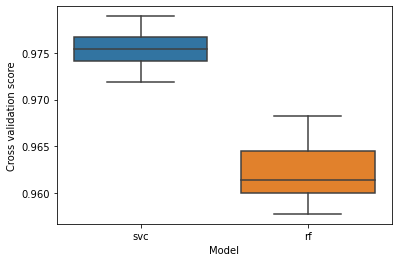

In [12]:
ax = gen_score_plot(score_df)
ax

In [13]:
from sklearn.base import clone

clone(rf)

RandomForestClassifier()